How do I upload colab to kaggle?
Go to your Google Colab project file and run the following commands:
1) ! pip install -q kaggle.
2) from google.colab import files.
files.upload()
3) ! mkdir ~/.kaggle.
! cp kaggle.json ~/.kaggle/
4) ! chmod 600 ~/.kaggle/kaggle.json.
5) ! kaggle datasets list. ...
! kaggle competitions download -c 'name-of-competition'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import lightgbm as lgb # LightGBM library needs to be installed to work correctly

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN
from collections import Counter

#Random forest
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

#Neural Network
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

#Bernoulli Restricted Boltzmann Machine
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

#Support Vector Machines
from sklearn import svm

from ipywidgets import interact
import ipywidgets as widgets
import warnings

sns.set(style='white', context='talk')
plt.style.use('seaborn')
warnings.filterwarnings("ignore")
%matplotlib inline

<ipython-input-1-7538e4a445a2>:53: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

uploaded = files.upload()

Mounted at /content/drive


Saving holidays_events.csv to holidays_events.csv
Saving oil.csv to oil.csv
Saving sample_submission.csv to sample_submission.csv
Saving stores.csv to stores.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Saving transactions.csv to transactions.csv


In [ ]:
df_holiday= pd.read_csv('/content/holidays_events.csv')
df_oil = pd.read_csv('/content/oil.csv')
df_store = pd.read_csv('/content/stores.csv')
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_transactions = pd.read_csv('/content/transactions.csv')
df_sample_submission = pd.read_csv('/content/sample_submission.csv')


In [ ]:
df_oil.head()

In [ ]:
df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

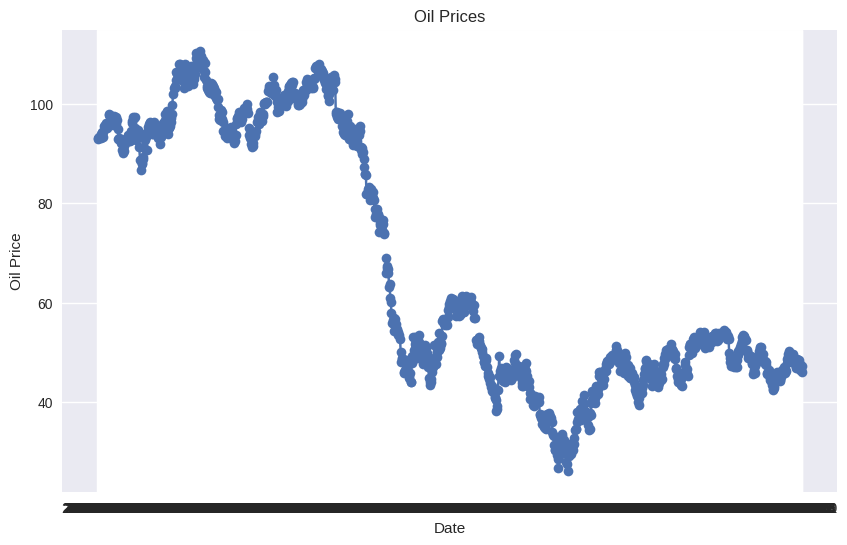

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['oil_price'], marker='o', linestyle='-')
plt.title('Oil Prices')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

In [ ]:
df_oil.isna().sum() # has missing values

date          0
oil_price    43
dtype: int64

In [ ]:
#Filling the missing oil values using the linear interpolation function of pandas
df_oil['oil_price'].interpolate(method='linear', inplace=True)

df_oil.at[0, 'oil_price'] = df_oil.at[1, 'oil_price']


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['oil_price'], marker='o', linestyle='-')
plt.title('Oil Prices  (after interpolation)')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

In [ ]:
#A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
df_holiday[(df_holiday['transferred'] == True) | (df_holiday['type'] == 'Transfer')]
#Because the competition tells us a holiday that is transferred should be treated like a normal day, we will change the type to normal so it does not affect our data. Days that have type 'Transfer' will be treated as regular holidays.
df_holiday.loc[df_holiday['transferred'], 'type'] = 'Normal'
df_holiday.loc[df_holiday['type'] == 'Transfer', 'type'] = 'Holiday'
df_holiday.loc[df_holiday['type'] == 'Bridge', 'type'] = 'Holiday'
df_holiday.drop('transferred', axis=1, inplace=True)
df_holiday


In [ ]:
df_holiday.isna().sum()
df_store.isna().sum()
df_train.isna().sum()
df_oil.isna().sum()

date         0
oil_price    0
dtype: int64

In [ ]:
# Convert all columns to datetime
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_holiday['date'] = pd.to_datetime(df_holiday['date'], format = '%Y-%m-%d')
df_oil['date'] = pd.to_datetime(df_oil['date'], format = '%Y-%m-%d')
df_test['date'] = pd.to_datetime(df_test['date'], format = '%Y-%m-%d')
df_transactions['date'] = pd.to_datetime(df_transactions['date'], format = '%Y-%m-%d')

In [ ]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Text(0, 0.5, 'Number of sales')

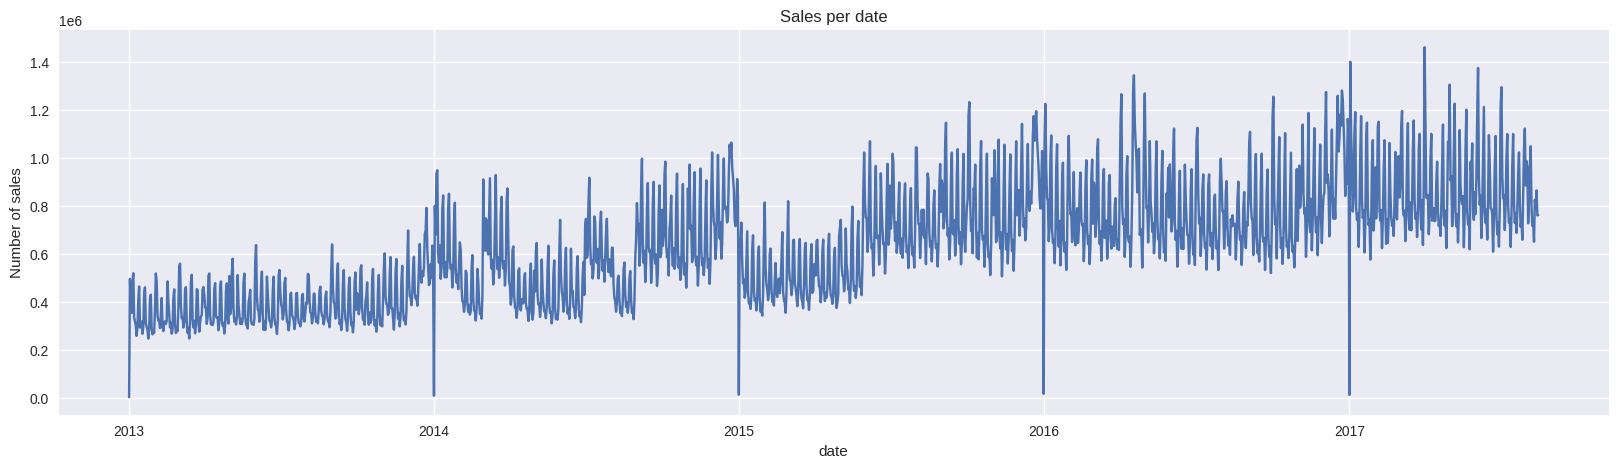

In [ ]:
plt.figure(figsize = (20,5))
sns.lineplot(df_train.groupby('date').sum()['sales'])
plt.title('Sales per date')
plt.xlabel('date')
plt.ylabel('Number of sales')

In [ ]:
df_train = pd.read_csv('/content/train.csv')
#Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
#A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.
df_train['date'] = pd.to_datetime(df_train.date)
df_train['last_day_of_month'] = df_train['date'].dt.is_month_end.astype(int)
df_train['day'] = df_train['date'].dt.day
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train.drop('date', axis=1, inplace=True)
# dropping the date of disaster and the 2months after it
indexes_to_drop = df_train[(df_train['year'] == 2016) & ((df_train['month'] == 4) | (df_train['month'] == 5)| (df_train['month'] == 6))].index
# use boolean indexing to drop rows
df_train = df_train.drop(indexes_to_drop)
# old index values dropped
df_train = df_train.reset_index(drop=True)
df_train['date']=df_train['year'].astype(str) + df_train['month'].astype(str).str.zfill(2)+ df_train['day'].astype(str).str.zfill(2)
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')


In [ ]:
df=df_train
df['payment?'] = np.where((df.last_day_of_month ==1)  | (df.day==15) , 'paid', 'no paid')

In [ ]:
justpaymentdays = df[ df['year']==2013 ]
pd.set_option('display.max_columns', None)
justpaymentdays

,id,store_nbr,family,sales,onpromotion,last_day_of_month,day,month,year,date,payment?
0,0,1,AUTOMOTIVE,0.00000,0,0,1,1,2013,2013-01-01,no paid
1,1,1,BABY CARE,0.00000,0,0,1,1,2013,2013-01-01,no paid
2,2,1,BEAUTY,0.00000,0,0,1,1,2013,2013-01-01,no paid
3,3,1,BEVERAGES,0.00000,0,0,1,1,2013,2013-01-01,no paid
4,4,1,BOOKS,0.00000,0,0,1,1,2013,2013-01-01,no paid
...,...,...,...,...,...,...,...,...,...,...,...
648643,648643,9,POULTRY,719.53503,0,1,31,12,2013,2013-12-31,paid
648644,648644,9,PREPARED FOODS,103.06000,0,1,31,12,2013,2013-12-31,paid
648645,648645,9,PRODUCE,0.00000,0,1,31,12,2013,2013-12-31,paid
648646,648646,9,SCHOOL AND OFFICE SUPPLIES,0.00000,0,1,31,12,2013,2013-12-31,paid


In [ ]:
df_train.drop('last_day_of_month', axis=1, inplace=True)
df_train

,id,store_nbr,family,sales,onpromotion,day,month,year,date,payment?
0,0,1,AUTOMOTIVE,0.000,0,1,1,2013,2013-01-01,no paid
1,1,1,BABY CARE,0.000,0,1,1,2013,2013-01-01,no paid
2,2,1,BEAUTY,0.000,0,1,1,2013,2013-01-01,no paid
3,3,1,BEVERAGES,0.000,0,1,1,2013,2013-01-01,no paid
4,4,1,BOOKS,0.000,0,1,1,2013,2013-01-01,no paid
...,...,...,...,...,...,...,...,...,...,...
2838721,3000883,9,POULTRY,438.133,0,15,8,2017,2017-08-15,paid
2838722,3000884,9,PREPARED FOODS,154.553,1,15,8,2017,2017-08-15,paid
2838723,3000885,9,PRODUCE,2419.729,148,15,8,2017,2017-08-15,paid
2838724,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,8,2017,2017-08-15,paid


In [ ]:
def join_dfs(df_train, df_oil, df_holiday, df_store):
    # merging oil prices with the dataframe
    merged_df = pd.merge(df_train, df_oil, on='date')
    # merging holidays with the dataframe
    merged_df = pd.merge(merged_df, df_holiday, on='date', how='left')
    # filling missing values
    merged_df = merged_df.fillna("None")
    # merging the store data with the dataframe
    merged_df = pd.merge(merged_df, df_store, on='store_nbr', how='left')

    return merged_df

In [ ]:
merged_df = join_dfs(df_train, df_oil, df_holiday, df_store)
merged_df.isna().sum() # no missing values

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
day            0
month          0
year           0
date           0
payment?       0
oil_price      0
type_x         0
locale         0
locale_name    0
description    0
city           0
state          0
type_y         0
cluster        0
dtype: int64

In [ ]:
merged_df['unique_id'] = merged_df['state'].astype(str) + '_' + merged_df['city'].astype(str)
merged_df = merged_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3',
                  'MarkDown4', 'MarkDown5', 'Type'], axis=1)
data = merged_df.rename(columns={'sales': 'y', 'date': 'ds'})
train = data.loc[data['ds'] < '2016-04-01']
valid = data.loc[data['ds'] >= '2016-04-01']
h = 15  #h daily

In [ ]:
merged_df['unique_id'] = merged_df['state'].astype(str) + '_' + merged_df['city'].astype(str)
merged_df = merged_df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3',
                  'MarkDown4', 'MarkDown5', 'Type'], axis=1)
data = merged_df.rename(columns={'sales': 'y', 'date': 'ds'})
train = data.loc[data['ds'] < '2016-04-01']
valid = data.loc[data['ds'] >= '2016-04-01']
h = 12  #h weekly, let set the data frame weekly

In [ ]:
merged_df.info

In [ ]:
merged_df.dtypes

In [ ]:
#boxplot
# Import Data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

df=df_train
df.reset_index(inplace=True)
# Prepare data
df['year'] = [d.year for d in df.year]
df['month'] = [d.strftime('%b') for d in df.year]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='sales', data=df, ax=axes[0])
sns.boxplot(x='month', y='sales', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()
# Prepare data
df['year'] = [d.year for d in merged_df]
df['month'] = [d.strftime('%b') for d in merged_df]
years = df['year'].unique()

#color
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'sales', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$ Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

In [ ]:
# checking trend seasonality and residuals
import statsmodels.api as sm
t_series = df_train.groupby(['date'])['sales'].agg(['mean']).reset_index().rename(columns={'mean': 'msales'})
t_series = t_series.set_index('date')
sample= t_series['msales'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(sample, model='additive')
fig = decomposition.plot()
fig.set_size_inches((14, 6))
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
train_cleaned_df = pivoted_train.reset_index()
train_cleaned_df['id']= train_cleaned_df.id.astype('str')

item_to_cat_df = items.merge(item_cats[['item_category_id','english_category']], how="inner", on="item_category_id")[['item_id','english_category']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

number = preprocessing.LabelEncoder()
train_cleaned_df[['english_category']] = number.fit_transform(train_cleaned_df.english_category)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'english_category'] + list(range(34))]
train_cleaned_df.head()


xgboost

In [ ]:

import xgboost as xgb
param = {
        'max_depth':10,
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3,
         'num_round':1000,
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

how to train

In [ ]:
data=merged_df
data = data.rename(columns={'sales': 'y', 'date': 'ds'})
train = data.loc[data['ds'] < '2015-01-01']
valid = data.loc[data['ds'] >= '2015-01-01']
h = 90

In [ ]:
data.rename(columns={'type_x': 'holidayornot'}, inplace=True)
data.head(1)

,id,store_nbr,family,y,onpromotion,day,month,year,ds,payment?,oil_price,holidayornot,locale,locale_name,description,city,state,type_y,cluster
0,0,1,AUTOMOTIVE,0.0,0,1,1,2013,2013-01-01,no paid,93.14,Holiday,National,Ecuador,Primer dia del ano,Quito,Pichincha,D,13


In [ ]:
data.drop('locale_name',axis=1, inplace=True)
data.drop('description',axis=1, inplace=True)

In [ ]:
data.head(2)

,id,store_nbr,family,y,onpromotion,ds,payment?,oil_price,holidayornot,locale,city,state,type_y,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013-01-01,no paid,93.14,Holiday,National,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013-01-01,no paid,93.14,Holiday,National,Quito,Pichincha,D,13


In [ ]:
data.drop('year',axis=1, inplace=True)

In [ ]:
!pip install mlforecast

In [ ]:
!pip install matplotlib

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

models = [make_pipeline(SimpleImputer(),
                        RandomForestRegressor(random_state=0, n_estimators=100)),
          XGBRegressor(random_state=0, n_estimators=100)]


model = MLForecast(models=models,
                   freq='d',
                   lags=[1,2,4],
                   lag_transforms={
                       1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)], # aplicado a uma janela W a partir do registro Lag
                   },
                   date_features=['day', 'year'],
                   num_threads=6)

In [ ]:
dynamic_features = ['onpromotion', 'payment?',  'oil_price','holidayornot']
static_features = [ 'store_nbr', 'family',  'locale','city', 'state','type_y','cluster']

In [ ]:
model.fit(train, id_col='id', time_col='ds', target_col='y', static_features=static_features)


ValueError: ignored

In [ ]:
p = model.predict(horizon=h, dynamic_dfs=[valid[['id','ds']+dynamic_features]])
p = p.merge(valid[['id', 'ds', 'y']], on=['id', 'ds'], how='left')

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=22)

In [ ]:
#lineer reg
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
y_predict

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_predict)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_predict)

In [ ]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor (n_estimators=100,random_state=22)
model.fit(X_train,y_train)
y_predi=model.predict(X_test)
y_predi

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_predi)

In [ ]:
#support vector
market=pd.read_csv( "company.csv" )

In [ ]:
X = market.iloc[:, [1,2]].values
y = market.iloc[:, 3].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 22)

In [ ]:
from sklearn.svm import SVR
classifier = SVR(kernel='linear')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

In [ ]:
data = [['Linear',0.0787732478768419,0.9282146803559008,1.9710166999999952
 ], ['Random Forrest',0.10295763234650994, 0.91164209732733,2.4260517694737644], ['SupportVector',0.40910398729049824,0.0794521078405328,28.8818896823162]]
summary = pd.DataFrame(data, columns=['Model',  'MAPE','R2','MSE'])
summary

In [ ]:
import xgboost as xgb
param = {
        'max_depth':10,
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3,
         'num_round':1000,
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

In [ ]:
#removed the stores that didn’t have data for the whole period. You can use everything I teach here with time series that have different sizes, but for simplicity I’ll not do it here.
#last_date_by_store = data.groupby('Store')['Date'].last()
#stores_with_full_data = last_date_by_store[last_date_by_store == data['Date'].max()].index
#data = data.loc[data['Store'].isin(stores_with_full_data)]

In [ ]:
data['unique_id'] = data['Store'].astype(str) + '_' + data['Dept'].astype(str)
data = data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3',
                  'MarkDown4', 'MarkDown5', 'Type'], axis=1)
data = data.rename(columns={'Weekly_Sales': 'y', 'Date': 'ds'})